In [1]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
# engine = create_engine("sqlite:///Resources/hawaii.sqlite")
inspector=inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [5]:
measurementColumns = inspector.get_columns('measurement')
for c in measurementColumns:
    print(c["name"],c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [6]:
stationColumns = inspector.get_columns('station')
for c in stationColumns:
    print(c['name'],c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [7]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

# measurementColumns = inspector.get_columns(measurement)


In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
mostRecentDate = session.query(Measurement.date) \
    .order_by(Measurement.date.desc()).first()
print(mostRecentDate)

('2017-08-23',)


<IPython.core.display.Javascript object>


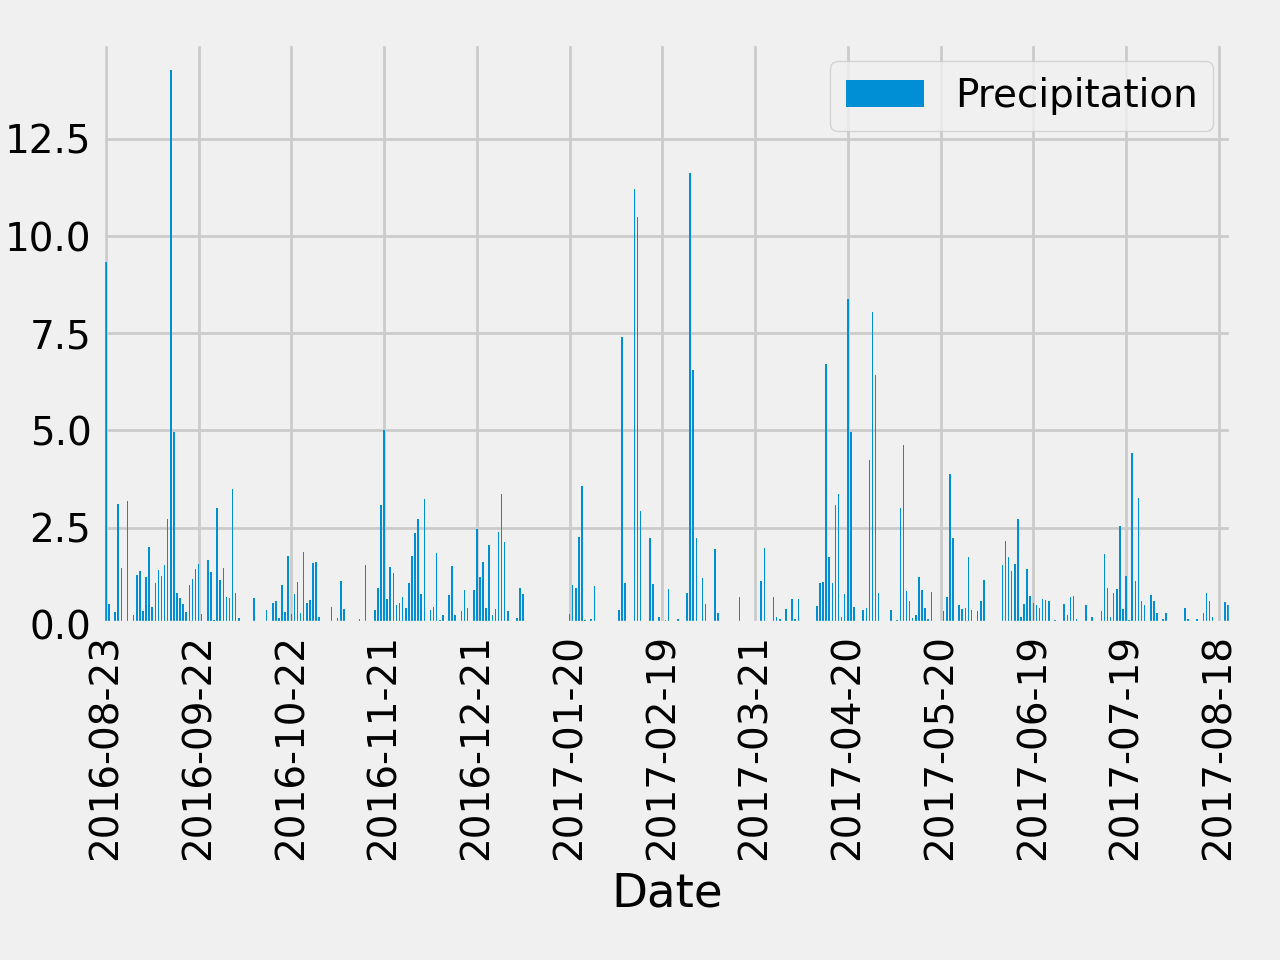

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
mostRecentSplit = mostRecentDate[0].split("-")
recentDate = dt.date(int(mostRecentSplit[0]),int(mostRecentSplit[1]),int(mostRecentSplit[2]))
# Calculate the date one year from the last date in data set.
yearAgo = recentDate - dt.timedelta(days=365)
xticks = np.arange(1,365,30)
xlabels=np.arange(yearAgo,recentDate,30)
# Perform a query to retrieve the data and precipitation scores
lastYearPrecip = session.query(Measurement.date, func.sum(Measurement.prcp))\
    .filter(Measurement.date >= yearAgo).group_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(lastYearPrecip, columns=['Date','Precipitation'])
precip_df.set_index('Date', inplace=True)
precip_df
# Sort the dataframe by date

precip_df = precip_df.sort_values(by='Date')
precip_df
# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(kind='bar', use_index=True)
plt.xticks(ticks=xticks,labels=xlabels)
plt.tight_layout()
plt.show()


In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,Precipitation
count,366.000000
mean,0.978907
std,1.776349
min,0.000000
25%,0.052500
50%,0.405000
75%,1.087500
max,14.280000


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number stations in the dataset
stationCount = session.query(Station.station).count()
print(stationCount)

9


In [16]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
activeStations = session.query(Measurement.station, func.count(Measurement.date))\
.group_by(Measurement.station).order_by(func.count(Measurement.date).desc()).all()
print(activeStations)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
mostActiveStation = session.query(Measurement.station, func.count(Measurement.date))\
.group_by(Measurement.station).order_by(func.count(Measurement.date).desc()).first()
print(mostActiveStation)

('USC00519281', 2772)


In [18]:
lowestTemp = session.query(Measurement.station, func.min(Measurement.tobs)\
                          .filter(Measurement.station == 'USC00519281')).first()
print(lowestTemp)

('USC00519281', 54.0)


In [19]:
highestTemp = session.query(Measurement.station, func.max(Measurement.tobs)\
                          .filter(Measurement.station == 'USC00519281')).first()
print(highestTemp)

('USC00519281', 85.0)


In [20]:
avgTemp = session.query(Measurement.station, func.avg(Measurement.tobs)\
                          .filter(Measurement.station == 'USC00519281')).first()
print(avgTemp)

('USC00519397', 71.66378066378067)


<IPython.core.display.Javascript object>


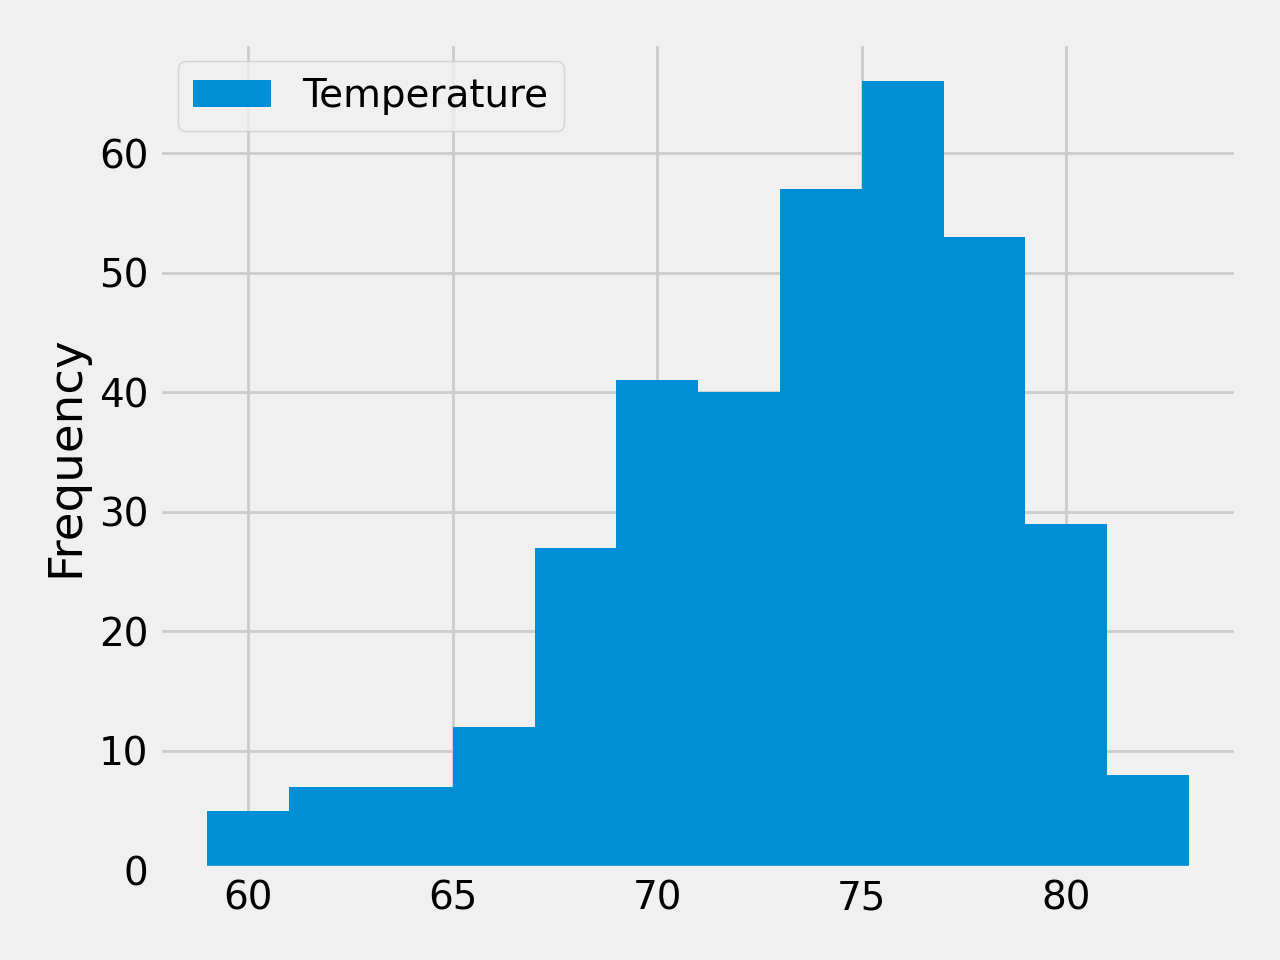

In [21]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

recentDate = dt.date(2017,8,23) #fix this
# Calculate the date one year from the last date in data set.
yearAgo = recentDate - dt.timedelta(days=365)
xticks = np.arange(1,365,30)
xlabels=np.arange(yearAgo,recentDate,30)
# Perform a query to retrieve the date and temperatures
lastYearTemp = session.query(Measurement.station,Measurement.date, Measurement.tobs)\
    .filter(Measurement.date >= yearAgo).filter(Measurement.station=='USC00519281').all()

# Save the query results as a Pandas DataFrame and set the index to the date column
temp_df = pd.DataFrame(lastYearTemp, columns=['Station','Date','Temperature'])
# precip_df.set_index('Date', inplace=True)
temp_df

# Use Pandas Plotting with Matplotlib to plot the data
temp_df.plot(kind='hist', bins=12)
# plt.xticks(ticks=xticks,labels=xlabels)
plt.tight_layout()
plt.show()

# Close session

In [22]:
# Close Session
session.close()